# Séries temporais
### Simples análise de algoritmos de classificação utilizando séries temporais

Primeiramente, vamos criar uma série temporal sintética. É um vetor de quantidade de chuva (milímetros) em cada dia do ano. Para modelar, vamos supor que a quantidade de chuvas é uma onda senoidal ao longo do ano.

Uma onda senoidal pode ser definida como $y(t) = H+A~sin(2\pi f~t + \phi)$, com H sendo a altura, ou o valor do eixo y onde o seno é zero (múltiplos de $\pi$), A é a amplitude da onda, ou a altura máxima que a onda chega (em relação à altura H), f é a frequência, ou o número de ondas por ciclo, e por fim $\phi$ é a fase, ou o deslocamento da onda.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

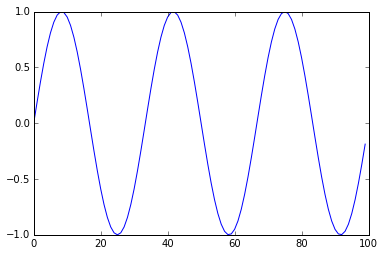

In [14]:
def onda_senoidal(altura, amplitude, frequencia, fase, passos):
    t = np.arange(passos)
    return altura + amplitude * np.sin(2 * np.pi * frequencia * t + fase)

x = np.arange(100)
y = onda_senoidal(altura=0, amplitude=1, frequencia=0.03, fase=0, passos=100)
plt.plot(x, y);

Para modelar nosso exemplo da chuva, pensemos que a onda pode variar de 0 a 300 milímetros de chuva. Portanto, utilizaremos uma amplitude de 150 e uma altura de 150. A frequência é de uma onda a cada ano, portanto $f = \frac{1}{365}$. Modelaremos ainda o mês de janeiro, ou mais especificamente o dia 1 de janeiro, como o pico das chuvas, e o mês de junho como o dia mais baixo de chuva; para isso, a defasagem deve ser de um quarto do tamanho da onda, multiplicado pela frequência angular, logo, $\frac{365}{4}\omega = \frac{365}{4}\frac{1}{365}2\pi = \frac{\pi}{2}$.

O gráfico abaixo mostra a quantidade de chuva medida a cada dia, ao longo de 5 anos, com $t=0$ indicando o dia 1 de janeiro do ano 0, e $t=1825$ (o último dia) sendo 31 de dezembro do ano 4.

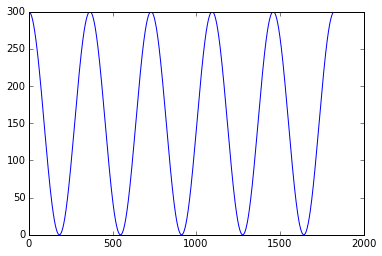

In [23]:
t = 365 * 5 # 5 anos
x = np.arange(t)
y = onda_senoidal(altura=150, amplitude=150, frequencia=1/365, fase=np.pi/2, passos=t)
plt.plot(x, y);